In [ ]:
# If not already, set runtime to GPU: Runtime > Change runtime type > GPU

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Optional (for nicer low-dim embeddings):
!pip install -q umap-learn

import umap

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === CONFIG ===
PROJECT_ROOT = "/content/drive/MyDrive/Indus-valley-phase-4"  # change if needed

SYMBOLS_DIR = os.path.join(PROJECT_ROOT, "symbols_64")           # 64x64 grayscale crops
OUTPUT_DIR  = os.path.join(PROJECT_ROOT, "outputs_phase4")       # where we store embeddings, plots etc.
CLASSICAL_DIR = os.path.join(PROJECT_ROOT, "classical_clusters") # Phase 3 csvs

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Symbols dir:", SYMBOLS_DIR)
print("Output dir:", OUTPUT_DIR)
print("Classical dir:", CLASSICAL_DIR)


Symbols dir: /content/drive/MyDrive/Indus-valley-phase-4/symbols_64
Output dir: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4
Classical dir: /content/drive/MyDrive/Indus-valley-phase-4/classical_clusters


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load DINOv2 ViT-S/14 from torch.hub
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
model.eval()
model.to(device)

# Check output dimension
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    out = model(dummy)
print("DINOv2 output shape:", out.shape)  # should be [1, 384] for ViT-S/14
EMBED_DIM = out.shape[-1]


Using device: cuda
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 413MB/s]


DINOv2 output shape: torch.Size([1, 384])


In [ ]:
from torchvision import transforms

# Standard ImageNet normalization (works for DINOv2)
dinov2_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

class SymbolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
        self.paths = sorted([
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(exts)
        ])

        # symbol_id = filename without extension (you can change this if you have a better scheme)
        self.symbol_ids = [os.path.splitext(os.path.basename(p))[0] for p in self.paths]

        print(f"Found {len(self.paths)} symbol images.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        symbol_id = self.symbol_ids[idx]

        img = Image.open(path).convert("L")   # grayscale
        img = img.convert("RGB")             # make 3-channel

        if self.transform:
            img = self.transform(img)

        return img, symbol_id, path

dataset = SymbolDataset(SYMBOLS_DIR, transform=dinov2_transform)


Found 5920 symbol images.


In [ ]:
BATCH_SIZE = 64

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

all_embeddings = []
all_symbol_ids = []
all_paths = []

model.eval()

with torch.no_grad():
    for batch_imgs, batch_ids, batch_paths in loader:
        batch_imgs = batch_imgs.to(device)
        feats = model(batch_imgs)          # shape: [B, EMBED_DIM]
        feats = feats.cpu().numpy()

        all_embeddings.append(feats)
        all_symbol_ids.extend(batch_ids)
        all_paths.extend(batch_paths)

X_dino = np.vstack(all_embeddings)
print("Embeddings shape:", X_dino.shape)   # expected ~ (N_symbols, 384)


Embeddings shape: (5920, 384)


In [ ]:
# Save embeddings as .npy
emb_path = os.path.join(OUTPUT_DIR, "X_dino_vits14.npy")
np.save(emb_path, X_dino)
print("Saved embeddings to:", emb_path)

# Save mapping: index -> symbol_id -> path
mapping_df = pd.DataFrame({
    "index": np.arange(len(all_symbol_ids)),
    "symbol_id": all_symbol_ids,
    "image_path": all_paths,
})
mapping_csv_path = os.path.join(OUTPUT_DIR, "symbols_mapping_dino.csv")
mapping_df.to_csv(mapping_csv_path, index=False)
print("Saved mapping CSV to:", mapping_csv_path)


Saved embeddings to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/X_dino_vits14.npy
Saved mapping CSV to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/symbols_mapping_dino.csv


In [ ]:
X = X_dino  # for readability

# PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X)
print("PCA shape:", X_pca_2d.shape)

# UMAP (2D) – for nicer non-linear structure
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap_2d = umap_reducer.fit_transform(X)
print("UMAP shape:", X_umap_2d.shape)

# Save to CSV
pca_csv = os.path.join(OUTPUT_DIR, "pca_dino_vits14_2d.csv")
umap_csv = os.path.join(OUTPUT_DIR, "umap_dino_vits14_2d.csv")

pd.DataFrame(X_pca_2d, columns=["pca1", "pca2"]).to_csv(pca_csv, index=False)
pd.DataFrame(X_umap_2d, columns=["umap1", "umap2"]).to_csv(umap_csv, index=False)

print("Saved PCA + UMAP CSVs.")


PCA shape: (5920, 2)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP shape: (5920, 2)
Saved PCA + UMAP CSVs.


In [ ]:
K = 40

kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
dino_labels = kmeans.fit_predict(X)

sil = silhouette_score(X, dino_labels)
print(f"DINOv2 KMeans: k={K}, silhouette={sil:.4f}")

# Cluster size distribution
unique, counts = np.unique(dino_labels, return_counts=True)
print("Cluster sizes:")
for u, c in zip(unique, counts):
    print(f"  Cluster {u:2d}: {c:4d} symbols")

# Save cluster assignments
dino_cluster_csv = os.path.join(OUTPUT_DIR, f"cluster_assignments_dino_vits14_k{K}.csv")
pd.DataFrame({"cluster_id": dino_labels}).to_csv(dino_cluster_csv, index=False)
print("Saved DINO cluster CSV to:", dino_cluster_csv)


DINOv2 KMeans: k=40, silhouette=0.1101
Cluster sizes:
  Cluster  0:  318 symbols
  Cluster  1:  136 symbols
  Cluster  2:   74 symbols
  Cluster  3:  212 symbols
  Cluster  4:  150 symbols
  Cluster  5:  196 symbols
  Cluster  6:  126 symbols
  Cluster  7:  156 symbols
  Cluster  8:   72 symbols
  Cluster  9:  188 symbols
  Cluster 10:  116 symbols
  Cluster 11:  194 symbols
  Cluster 12:  160 symbols
  Cluster 13:  258 symbols
  Cluster 14:  222 symbols
  Cluster 15:  116 symbols
  Cluster 16:   52 symbols
  Cluster 17:   96 symbols
  Cluster 18:  268 symbols
  Cluster 19:  306 symbols
  Cluster 20:  104 symbols
  Cluster 21:   86 symbols
  Cluster 22:   70 symbols
  Cluster 23:   98 symbols
  Cluster 24:   88 symbols
  Cluster 25:  190 symbols
  Cluster 26:   90 symbols
  Cluster 27:  248 symbols
  Cluster 28:  130 symbols
  Cluster 29:  188 symbols
  Cluster 30:   70 symbols
  Cluster 31:  252 symbols
  Cluster 32:   38 symbols
  Cluster 33:   84 symbols
  Cluster 34:  132 symbols
 

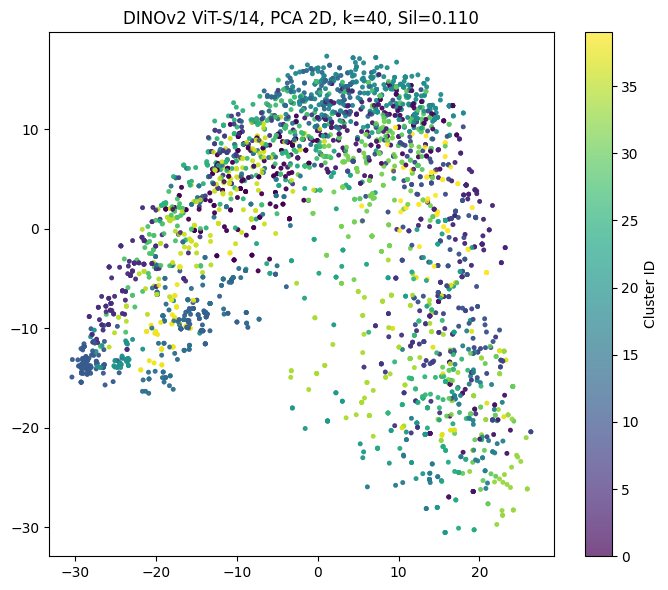

Saved plot to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_vits14_k40_pca_scatter.png


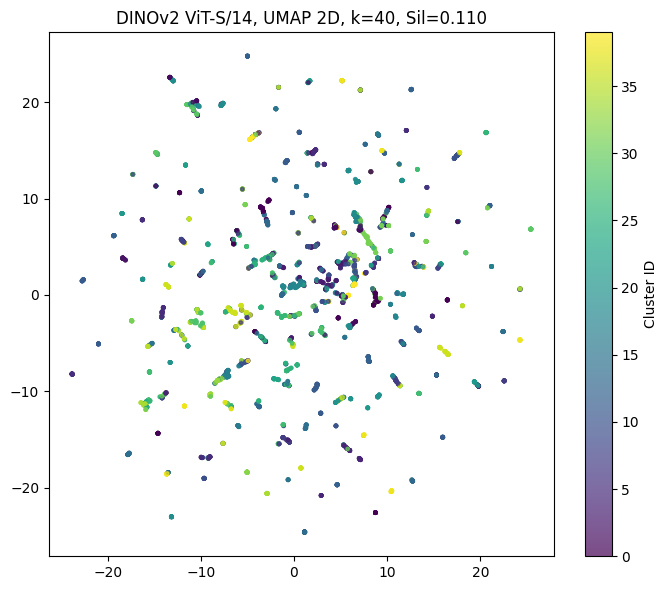

Saved plot to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_vits14_k40_umap_scatter.png


In [ ]:
def scatter_plot_2d(emb2d, labels, title, out_path):
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=6, alpha=0.7)
    plt.colorbar(scatter, label="Cluster ID")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()
    print("Saved plot to:", out_path)

pca_plot_path = os.path.join(OUTPUT_DIR, f"dino_vits14_k{K}_pca_scatter.png")
umap_plot_path = os.path.join(OUTPUT_DIR, f"dino_vits14_k{K}_umap_scatter.png")

scatter_plot_2d(X_pca_2d, dino_labels,
                title=f"DINOv2 ViT-S/14, PCA 2D, k={K}, Sil={sil:.3f}",
                out_path=pca_plot_path)

scatter_plot_2d(X_umap_2d, dino_labels,
                title=f"DINOv2 ViT-S/14, UMAP 2D, k={K}, Sil={sil:.3f}",
                out_path=umap_plot_path)


In [ ]:
# Load your Phase 3 rich cluster CSV
rich_cluster_csv = os.path.join(CLASSICAL_DIR, "cluster_assignments_rich_k40.csv")
rich_df = pd.read_csv(rich_cluster_csv)

# Assumption: rich_df has a column named 'cluster_id'
rich_labels = rich_df['cluster_id'].values

# Ensure same length
print("Rich labels:", len(rich_labels), "DINO labels:", len(dino_labels))

if len(rich_labels) != len(dino_labels):
    raise ValueError("Mismatch between number of symbols in rich clusters and DINO clusters.")

ari = adjusted_rand_score(rich_labels, dino_labels)
nmi = normalized_mutual_info_score(rich_labels, dino_labels)

print(f"ARI (rich vs dino): {ari:.4f}")
print(f"NMI (rich vs dino): {nmi:.4f}")

# Save metrics
metrics_path = os.path.join(OUTPUT_DIR, f"dino_vits14_k{K}_comparison_metrics.txt")
with open(metrics_path, "w") as f:
    f.write(f"DINOv2 ViT-S/14 vs Classical Rich, k={K}\n")
    f.write(f"Silhouette (DINO): {sil:.6f}\n")
    f.write(f"ARI: {ari:.6f}\n")
    f.write(f"NMI: {nmi:.6f}\n")
print("Saved comparison metrics to:", metrics_path)


Rich labels: 5920 DINO labels: 5920
ARI (rich vs dino): 0.0859
NMI (rich vs dino): 0.3161
Saved comparison metrics to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_vits14_k40_comparison_metrics.txt


In [ ]:
import numpy as np
from collections import defaultdict

K = len(np.unique(dino_labels))  # should be 40

cluster_to_indices = defaultdict(list)
for idx, cid in enumerate(dino_labels):
    cluster_to_indices[int(cid)].append(idx)

for cid in sorted(cluster_to_indices.keys()):
    print(f"Cluster {cid:2d}: {len(cluster_to_indices[cid])} symbols")


Cluster  0: 318 symbols
Cluster  1: 136 symbols
Cluster  2: 74 symbols
Cluster  3: 212 symbols
Cluster  4: 150 symbols
Cluster  5: 196 symbols
Cluster  6: 126 symbols
Cluster  7: 156 symbols
Cluster  8: 72 symbols
Cluster  9: 188 symbols
Cluster 10: 116 symbols
Cluster 11: 194 symbols
Cluster 12: 160 symbols
Cluster 13: 258 symbols
Cluster 14: 222 symbols
Cluster 15: 116 symbols
Cluster 16: 52 symbols
Cluster 17: 96 symbols
Cluster 18: 268 symbols
Cluster 19: 306 symbols
Cluster 20: 104 symbols
Cluster 21: 86 symbols
Cluster 22: 70 symbols
Cluster 23: 98 symbols
Cluster 24: 88 symbols
Cluster 25: 190 symbols
Cluster 26: 90 symbols
Cluster 27: 248 symbols
Cluster 28: 130 symbols
Cluster 29: 188 symbols
Cluster 30: 70 symbols
Cluster 31: 252 symbols
Cluster 32: 38 symbols
Cluster 33: 84 symbols
Cluster 34: 132 symbols
Cluster 35: 96 symbols
Cluster 36: 254 symbols
Cluster 37: 50 symbols
Cluster 38: 114 symbols
Cluster 39: 122 symbols


In [ ]:
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

def make_cluster_mosaic(
    cluster_id,
    max_symbols=25,
    grid_cols=5,
    save=True,
    show=True
):
    """
    Create a grid image of up to `max_symbols` symbols from one cluster.
    """
    indices = cluster_to_indices[cluster_id]
    if len(indices) == 0:
        print(f"Cluster {cluster_id} is empty.")
        return

    # pick first max_symbols indices (you can also random.sample if you want randomness)
    indices = indices[:max_symbols]

    grid_rows = math.ceil(len(indices) / grid_cols)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 1.5, grid_rows * 1.5))
    axes = np.array(axes).reshape(grid_rows, grid_cols)

    for ax in axes.flat:
        ax.axis("off")

    for ax, idx in zip(axes.flat, indices):
        # dataset[idx] returns (tensor, symbol_id, path)
        _, symbol_id, path = dataset[idx]
        img = Image.open(path).convert("L")
        ax.imshow(img, cmap="gray")
        ax.set_title(symbol_id, fontsize=6)
        ax.axis("off")

    fig.suptitle(f"DINO Cluster {cluster_id} (n={len(cluster_to_indices[cluster_id])})",
                 fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.94])

    if save:
        out_path = os.path.join(OUTPUT_DIR, f"dino_cluster_{cluster_id:02d}_mosaic.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved mosaic for cluster {cluster_id} to: {out_path}")

    if show:
        plt.show()
    else:
        plt.close()


In [ ]:
# All clusters (might take a bit, but fine):
for cid in sorted(cluster_to_indices.keys()):
    make_cluster_mosaic(cid, max_symbols=25, grid_cols=5, save=True, show=False)

# Or just a few, e.g. clusters 0, 1, 2:
# for cid in [0, 1, 2]:
#     make_cluster_mosaic(cid, max_symbols=25, grid_cols=5, save=True, show=True)


Saved mosaic for cluster 0 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_00_mosaic.png
Saved mosaic for cluster 1 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_01_mosaic.png
Saved mosaic for cluster 2 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_02_mosaic.png
Saved mosaic for cluster 3 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_03_mosaic.png
Saved mosaic for cluster 4 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_04_mosaic.png
Saved mosaic for cluster 5 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_05_mosaic.png
Saved mosaic for cluster 6 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_06_mosaic.png
Saved mosaic for cluster 7 to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/dino_cluster_07_mosaic.png
Saved mosaic for cluster 8 to: /content/drive/MyDrive/Indus-vall

In [ ]:
!pip install -q transformers

import torch
from transformers import AutoImageProcessor, Dinov2Model, AutoConfig

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

ATTN_MODEL_NAME = "facebook/dinov2-small"

# 1) Load config with output_attentions=True
config = AutoConfig.from_pretrained(ATTN_MODEL_NAME)
config.output_attentions = True

# 2) Load processor + model with this config
image_processor = AutoImageProcessor.from_pretrained(ATTN_MODEL_NAME)
attn_model = Dinov2Model.from_pretrained(ATTN_MODEL_NAME, config=config).to(device)
attn_model.eval()

print("Attention model loaded:", ATTN_MODEL_NAME)
print("Config output_attentions:", attn_model.config.output_attentions)



Using device: cuda
Attention model loaded: facebook/dinov2-small
Config output_attentions: True


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def visualize_attention_for_symbol(idx, head=0, save=True, show=True):
    """
    idx  : index in your SymbolDataset / dino_labels
    head : which attention head to visualize
    """
    attn_model.eval()

    # Get symbol info
    _, symbol_id, path = dataset[idx]

    # Load original image and make it RGB for the processor
    img_orig = Image.open(path).convert("RGB")
    img_resized = img_orig.resize((224, 224))
    img_np_gray = np.array(img_resized.convert("L"))  # for nice grayscale display

    # Preprocess with HF image processor
    inputs = image_processor(images=img_resized, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward with attentions
    with torch.no_grad():
        outputs = attn_model(**inputs, output_attentions=True, return_dict=True)

    # ---- SAFETY CHECKS ----
    attentions = outputs.attentions
    if attentions is None:
        print("outputs.attentions is None – model is not returning attentions.")
        print("Check that attn_model.config.output_attentions == True.")
        return

    # attentions: tuple of (num_layers, batch, heads, seq, seq)
    print(f"Got {len(attentions)} attention layers.")
    last_layer_attn = attentions[-1]          # shape: [batch, heads, seq, seq]
    last_layer_attn = last_layer_attn[0]      # [heads, seq, seq]

    num_heads, seq_len, _ = last_layer_attn.shape
    if head >= num_heads:
        print(f"Head {head} out of range, num_heads={num_heads}")
        return

    attn = last_layer_attn[head]             # [seq, seq]

    # CLS token attention
    cls_attn = attn[0]                       # [seq]
    cls_to_patches = cls_attn[1:]            # drop CLS->CLS

    num_patches = cls_to_patches.shape[0]
    feat_size = int(np.sqrt(num_patches))
    if feat_size * feat_size != num_patches:
        print(f"Unexpected number of patches: {num_patches}")
        return

    attn_map = cls_to_patches.reshape(feat_size, feat_size).cpu().numpy()

    # Upsample to 224x224
    attn_resized = cv2.resize(attn_map, (224, 224))
    attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)

    # Make heatmap
    heatmap = cv2.applyColorMap((attn_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Grayscale -> 3-channel for overlay
    img_rgb_gray = np.stack([img_np_gray]*3, axis=-1)
    overlay = (0.5 * img_rgb_gray + 0.5 * heatmap).astype(np.uint8)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(img_np_gray, cmap="gray")
    axes[0].set_title(f"Symbol {symbol_id}")
    axes[0].axis("off")

    axes[1].imshow(heatmap)
    axes[1].set_title("Attention heatmap")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()

    if save:
        out_path = os.path.join(OUTPUT_DIR, f"attn_symbol_{symbol_id}_head{head}.png")
        plt.savefig(out_path, dpi=300)
        print("Saved attention overlay to:", out_path)

    if show:
        plt.show()
    else:
        plt.close()


Got 12 attention layers.
Saved attention overlay to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/attn_symbol_page073_M-97_A_c0_sym_001_head0.png


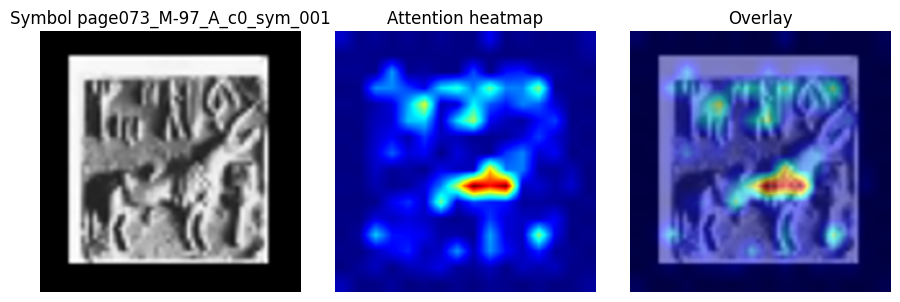

Got 12 attention layers.
Saved attention overlay to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/attn_symbol_page073_M-97_A_c0_sym_001_head1.png


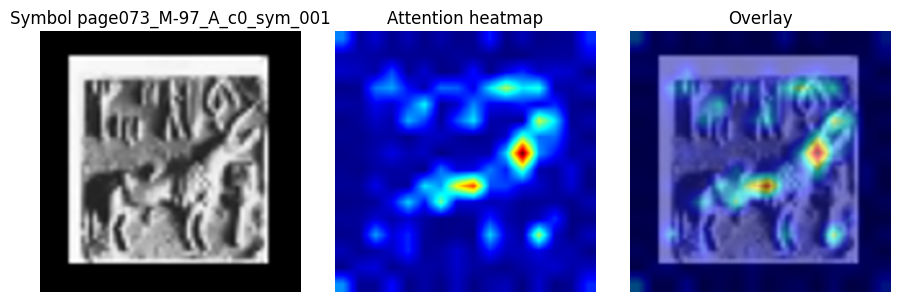

Got 12 attention layers.
Saved attention overlay to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/attn_symbol_page073_M-97_A_c0_sym_001_head2.png


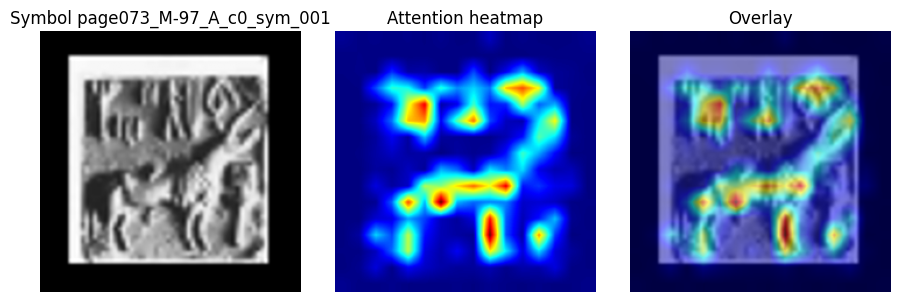

Got 12 attention layers.
Saved attention overlay to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/attn_symbol_page073_M-97_A_c0_sym_001_head3.png


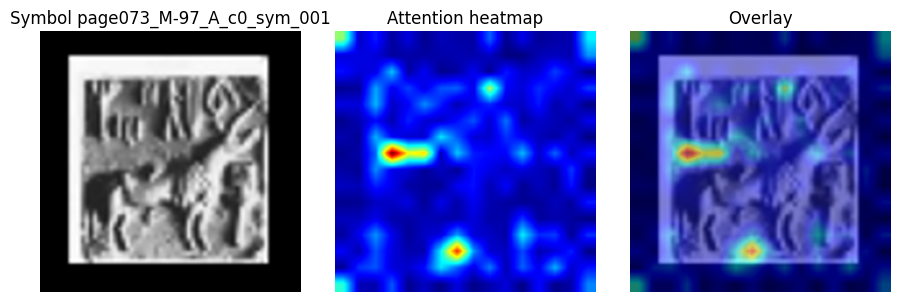

Got 12 attention layers.
Saved attention overlay to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/attn_symbol_page073_M-97_A_c0_sym_001_head4.png


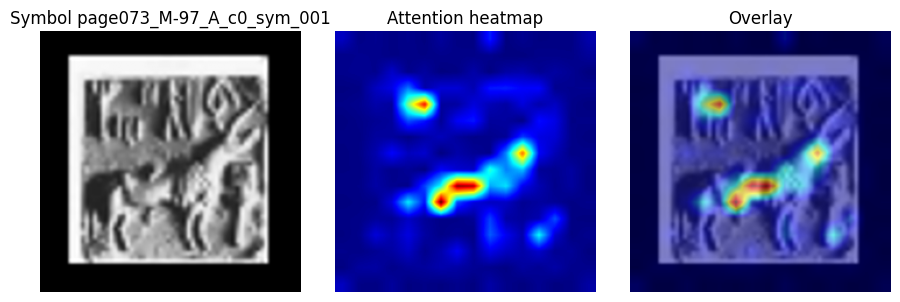

Got 12 attention layers.
Saved attention overlay to: /content/drive/MyDrive/Indus-valley-phase-4/outputs_phase4/attn_symbol_page073_M-97_A_c0_sym_001_head5.png


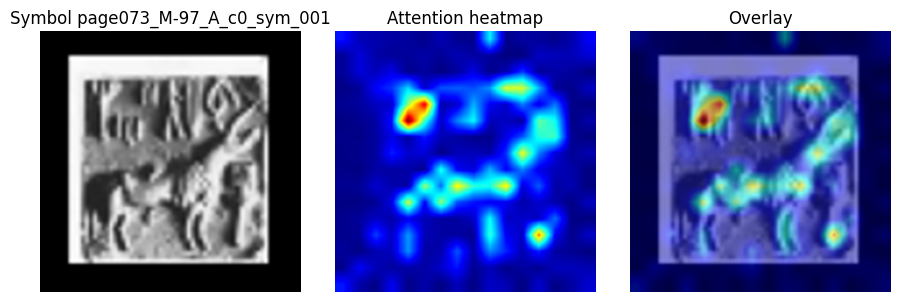

In [ ]:
example_indices = [221]  # adjust to any valid indices you want

for idx in example_indices:
    for h in range(6):  # or up to num_heads
      visualize_attention_for_symbol(idx, head=h, save=True, show=True)


In [ ]:
for i in range(10):
    _, sid, path = dataset[i]
    print(i, sid, path)


0 page039_M-4_B_c0_sym_001 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page039_M-4_B_c0_sym_001.png
1 page046_M-12_a_c1_sym_001 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_001.png
2 page046_M-12_a_c1_sym_002 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_002.png
3 page046_M-12_a_c1_sym_003 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_003.png
4 page046_M-12_a_c1_sym_004 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_004.png
5 page046_M-12_a_c1_sym_005 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_005.png
6 page046_M-12_a_c1_sym_006 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_006.png
7 page046_M-12_a_c1_sym_007 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_c1_sym_007.png
8 page046_M-12_a_c1_sym_008 /content/drive/MyDrive/Indus-valley-phase-4/symbols_64/page046_M-12_a_